In [1]:
# Parameters
symbol = '^GSPC'
start_date = '1970'

In [2]:
%matplotlib inline

In [440]:
import pandas as pd
import numpy as np
import yfinance as yf

import numba
from scipy.optimize import minimize
from scipy import stats

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

from IPython.display import set_matplotlib_formats

# set_matplotlib_formats('svg')
mpl.rcParams['figure.figsize'] = [16, 12]

In [4]:
def plot_dd(rets):
    c_pl = rets.add(1).cumprod()

    c_pl.plot(lw=1, color='black', logy=True)
    plt.fill_between(
        c_pl.index,
        c_pl,
        c_pl.cummax(),
        facecolor='red',
        alpha=0.5,
    )

In [636]:
# https://fred.stlouisfed.org/series/FEDFUNDS
fed_rate = pd.read_csv("FEDFUNDS.csv").rename(columns=lambda xs: xs.lower())
fed_rate.date = pd.to_datetime(fed_rate.date)
fed_rate = fed_rate.set_index("date")
fed_rate

,fedfunds
date,
1954-07-01,0.80
1954-08-01,1.22
1954-09-01,1.07
1954-10-01,0.85
1954-11-01,0.83
...,...
2023-09-01,5.33
2023-10-01,5.33
2023-11-01,5.33


In [5]:
# https://wholesale.banking.societegenerale.com/en/prime-services-indices/
sg_cta = pd.read_csv("sg_indices.csv").rename(columns={"trade_date": "date"})
sg_cta["date"] = pd.to_datetime(sg_cta["date"])
sg_cta = sg_cta.set_index("date")
cta_ret = sg_cta["SG CTA Index"].transform(lambda xs: xs / xs.shift() - 1)

In [218]:
symbols = {}
for s in ["SPY", "AGG", "DBMF"]:
    df = yf.Ticker(s).history(period='max', auto_adjust=True)
    df.index = df.index.tz_convert(None).floor("D")
    df["ret"] = df["Close"].transform(lambda xs: xs / xs.shift() - 1)
    symbols[s.lower()] = df

In [239]:
rets = pd.DataFrame({k: v["ret"] for k, v in symbols.items()})
rets["cta"] = cta_ret
rets = rets.dropna(subset=["spy", "agg", "cta"])

In [576]:
borrow = (
    fed_rate.iloc[fed_rate.index.searchsorted(rets.index) - 1]
    .set_index(rets.index).fedfunds
    .add(1.5).div(100).div(250).rename(None)
)

In [240]:
# DBMF really does seem to track the CTA index with an additional 2% from not charging as much

from sklearn.linear_model import LinearRegression

dbmf_calibration_df = rets[["cta", "dbmf"]].dropna()

model = LinearRegression()
model.fit(dbmf_calibration_df[["cta"]], dbmf_calibration_df["dbmf"])

dbmf_proxy = model.predict(rets[["cta"]])

rets["dbmf_proxy"] = dbmf_proxy

(model.coef_[0], model.intercept_ * 250)

(0.9960515835280288, 0.02153269380990468)

In [418]:
stds = rets[["spy", "agg", "dbmf_proxy"]].std()
stds /= stds["spy"]
stds

spy           1.000000
agg           0.276795
dbmf_proxy    0.418107
dtype: float64

In [619]:
weights = stats.dirichlet.rvs([1, 1, 1], 50)
weights /= (((weights * stds.values)**2).sum(axis=1)**0.5)[:, None]

labels = [f"{a * 100:03.0f}_{b * 100:03.0f}_{c * 100:03.0f}" for a, b, c in weights]
weights = pd.DataFrame(weights, index=labels, columns=["spy", "agg", "dbmf_proxy"])
weights

,spy,agg,dbmf_proxy
082_009_137,0.820770,0.086299,1.365104
037_034_221,0.371536,0.335299,2.209406
086_125_090,0.858902,1.252601,0.901522
099_047_021,0.987607,0.472983,0.207020
093_018_090,0.925722,0.184988,0.896235
023_007_233,0.228467,0.074082,2.327959
099_018_034,0.988464,0.176530,0.342872
100_020_016,0.996219,0.200440,0.159895
099_024_027,0.991282,0.239917,0.272169
057_001_197,0.566652,0.007855,1.970679


In [620]:
leverage_cost = (weights.sum(axis=1) - 1).to_frame().dot(borrow.to_frame().T).T
port_rets = rets[["spy", "agg", "dbmf_proxy"]].dot(weights.T) - leverage_cost

In [621]:
sharpe = lambda xs: xs.mean() / xs.std() * 250**0.5

In [622]:
port_sharpes = sharpe(port_rets).sort_values()
best_port = port_sharpes.index[-1]
port_sharpes

009_360_008    0.205631
012_358_014    0.232380
004_342_077    0.296598
021_327_088    0.394278
064_276_006    0.459964
071_254_007    0.492808
005_080_233    0.540360
008_084_232    0.551763
079_211_049    0.594352
048_240_138    0.596029
028_162_203    0.605003
095_113_009    0.605245
096_098_006    0.606124
096_102_011    0.611729
023_007_233    0.616429
097_090_016    0.622934
100_011_012    0.630788
027_026_230    0.630888
097_086_023    0.633758
100_019_015    0.634529
100_020_016    0.635745
095_107_030    0.636597
099_047_021    0.639569
100_003_024    0.646247
094_104_037    0.646966
099_024_027    0.650562
099_018_034    0.659784
037_034_221    0.665222
098_006_044    0.671723
097_034_049    0.676144
098_014_048    0.676324
096_051_054    0.679715
097_001_059    0.688022
092_089_071    0.688458
086_125_090    0.691295
089_106_082    0.693177
053_066_198    0.705475
092_067_086    0.706908
055_060_195    0.710721
092_046_088    0.711861
057_001_197    0.713689
093_018_090    0

In [623]:
def plot_dd(rets):
    c_pl = rets.add(1).cumprod()

    c_pl.plot(lw=1, color='black', logy=True)
    plt.fill_between(
        c_pl.index,
        c_pl,
        c_pl.cummax(),
        facecolor='red',
        alpha=0.5,
    )

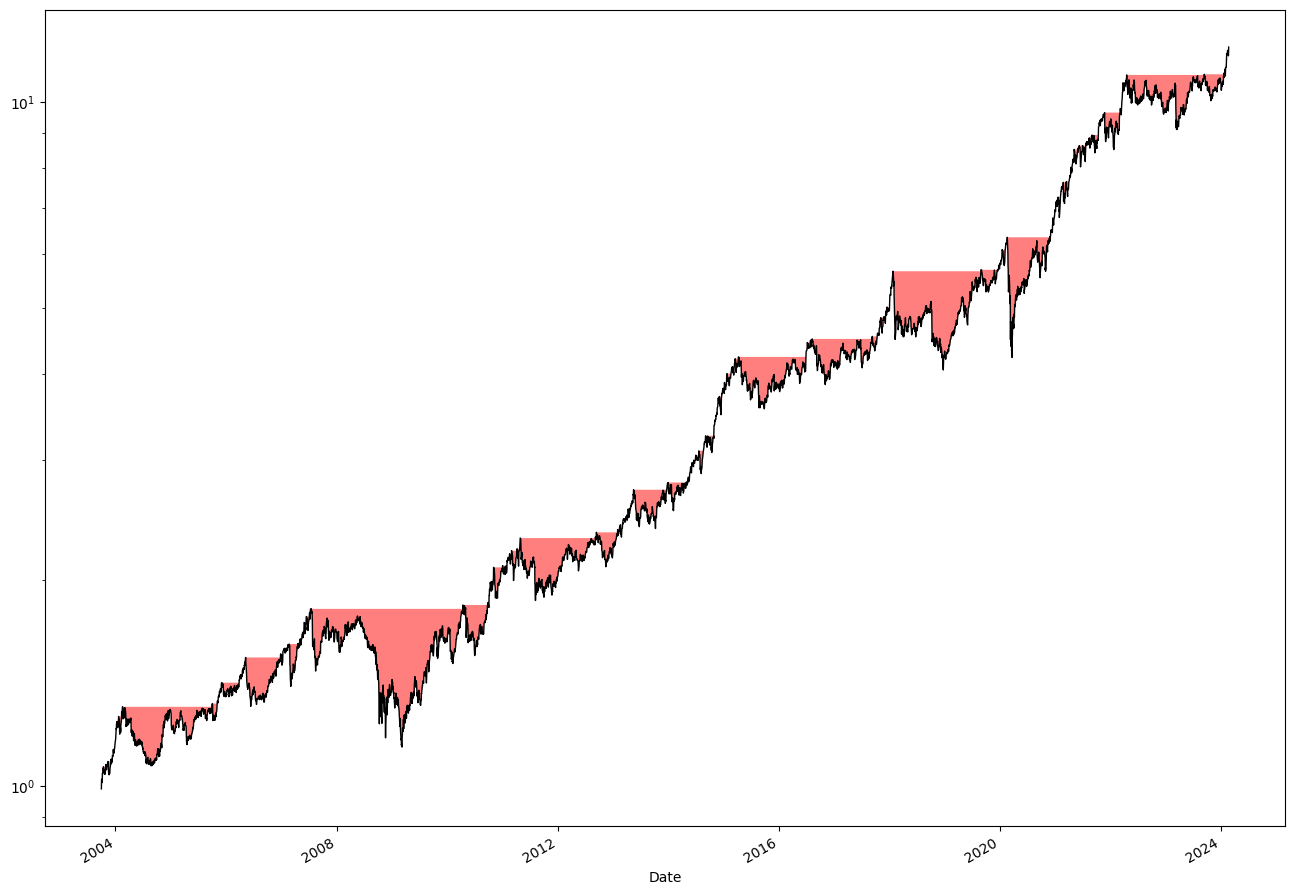

In [624]:
plot_dd(port_rets[best_port])

<AxesSubplot: xlabel='Date'>

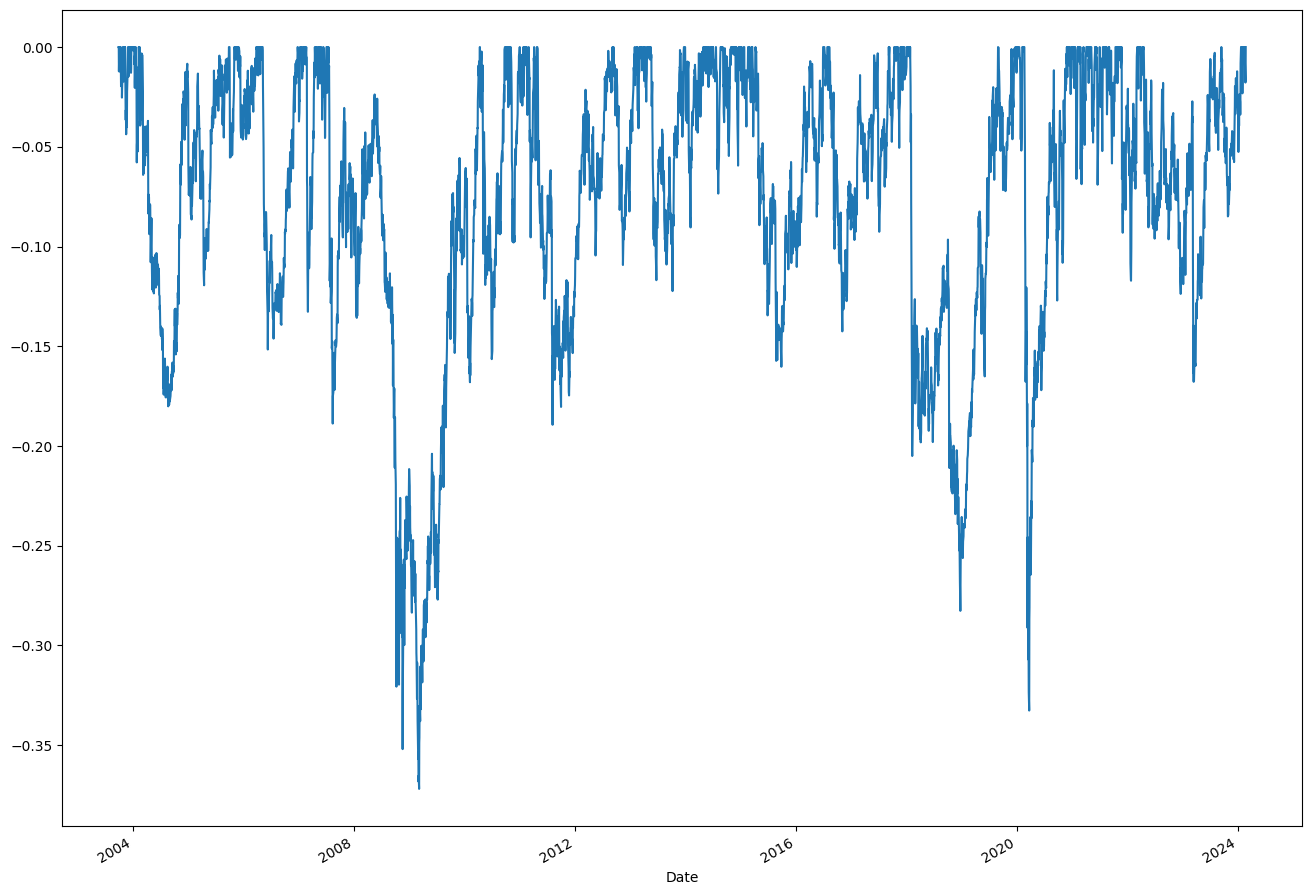

In [625]:
port_rets[best_port].add(1).cumprod().transform(lambda xs: xs / xs.cummax() - 1).plot()

In [626]:
def logret(r):
    return r.add(1).apply(np.log).mean().mul(250).apply(np.exp).sub(1)

In [627]:
l_rets = pd.concat([
    logret(l * port_rets.loc[:, port_sharpes.index[::-1]]
           .sub((l - 1) * borrow, axis=0)).rename(f"{l:.1f}") 
    for l in np.linspace(1, 3, 10)
], axis=1)
l_rets.columns.name = "Leverage"
l_rets.style.highlight_max(axis=1)

Leverage,1.0,1.2,1.4,1.7,1.9,2.1,2.3,2.6,2.8,3.0
081_013_140,0.128718,0.144482,0.154965,0.160008,0.159531,0.153527,0.142071,0.125311,0.103470,0.076837
082_009_137,0.128625,0.144362,0.154814,0.159825,0.159313,0.153275,0.141784,0.124990,0.103114,0.076449
083_010_135,0.128546,0.144266,0.154703,0.159701,0.159177,0.153129,0.141630,0.124829,0.102949,0.076282
069_076_165,0.125682,0.140815,0.150704,0.155198,0.154224,0.147782,0.135950,0.118880,0.096797,0.069990
076_098_141,0.124440,0.139309,0.148946,0.153206,0.152017,0.145383,0.133382,0.116167,0.093962,0.067055
090_012_103,0.125735,0.140798,0.150587,0.154955,0.153829,0.147215,0.135193,0.117920,0.095625,0.068602
090_008_102,0.125647,0.140683,0.150442,0.154778,0.153619,0.146970,0.134912,0.117603,0.095272,0.068215
090_035_099,0.124727,0.139584,0.149180,0.153372,0.152090,0.145342,0.133210,0.115851,0.093494,0.066433
093_018_090,0.123695,0.138286,0.147609,0.151525,0.149968,0.142948,0.130554,0.112944,0.090353,0.063077
057_001_197,0.123654,0.138171,0.147389,0.151169,0.149442,0.142222,0.129597,0.111733,0.088867,0.061303


In [675]:
best_half = weights.loc[port_sharpes.index[::-1]][:25].mean()
best_half /= best_half.sum()
best_half

spy           0.362787
agg           0.176903
dbmf_proxy    0.460310
dtype: float64

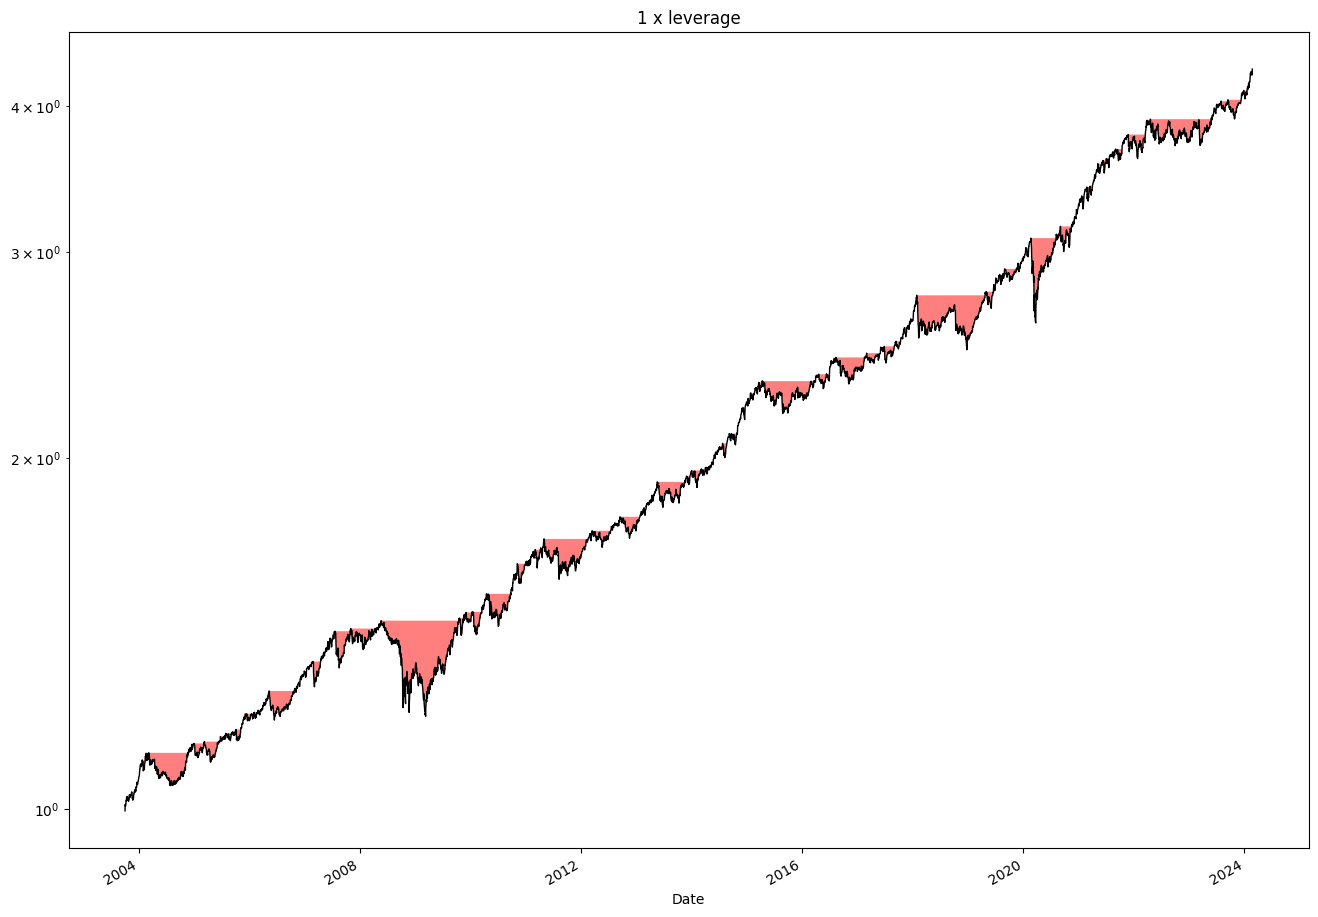

In [681]:
best_half_rets = (rets * best_half).sum(axis=1)
plot_dd(best_half_rets - 0. * borrow)
plt.title("1 x leverage");

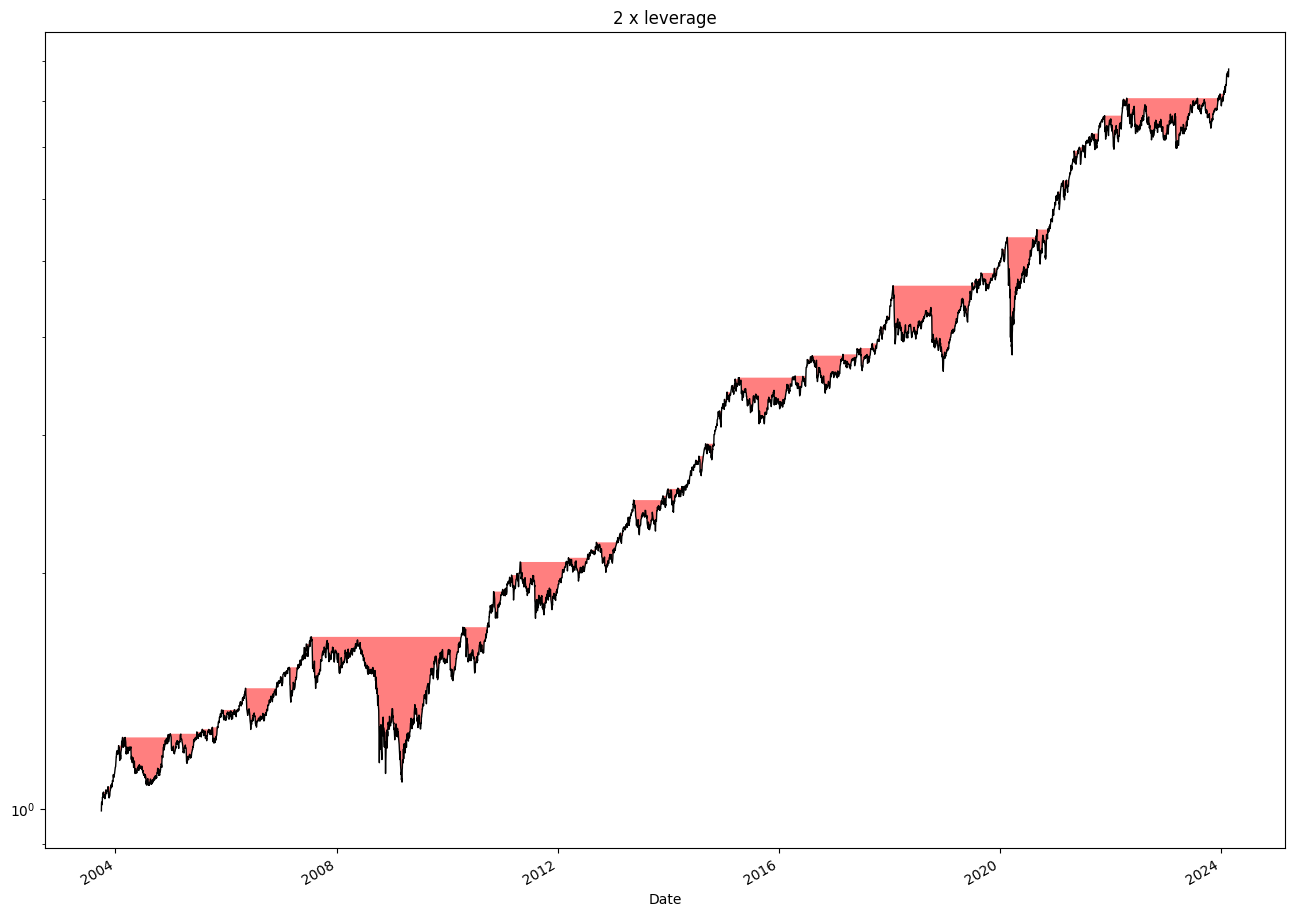

In [682]:
plot_dd(best_half_rets * 2 - borrow)
plt.title("2 x leverage");